# CARLINI WAGNER #

#### *Import* 

In [ ]:
import os
import re
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
from torchvision import transforms
import torch
from torch.nn import CrossEntropyLoss
import torch.nn as nn
from art.estimators.classification import PyTorchClassifier
import tensorflow as tf
from matplotlib import pyplot as plt
# Import all L-distance based attacks
from art.attacks.evasion import CarliniL2Method, CarliniL0Method, CarliniLInfMethod
from RESNET import ResNet
from utils import get_labels
from utils import load_state_dict
from utils import load_image_NN1
from utils import load_test_image_NN2
from utils import load_test_image_NN2_preprocessed

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = str(device)
print(device)

In [ ]:
if device in 'cuda':
    print("Import Inception.Inception")
    import inception
    nn1 = inception.InceptionResnetV1(pretrained='vggface2').eval()
    device_classifier = "gpu"
elif device == "cpu":
    print("Import Facenet.Inception")
    from facenet_pytorch import InceptionResnetV1
    nn1 = InceptionResnetV1(pretrained='vggface2').eval()
    device_classifier = "cpu"

#### Inizializzazione

In [ ]:
# ----------------------------nn1-----------------------
nn1.classify = True
nn1.to(device)
model_nn1 = PyTorchClassifier(nn1,input_shape=[224,224], loss=CrossEntropyLoss(),nb_classes=8631, device_type=device_classifier) #This class implements a classifier with the PyTorch framework.

# ---------------------nn2-----------------------------
nn2 = ResNet.resnet50(num_classes=8631, include_top=True)
load_state_dict(nn2,'resnet50_scratch_weight.pkl')
nn2.eval()
nn2.to(device)
model_nn2 = PyTorchClassifier(nn2,input_shape=[224,224], loss=CrossEntropyLoss(),nb_classes=8631, device_type="gpu")

#--------------------------------------------------------
LABELS = get_labels()



## Untargeted Attack on all test set

In [ ]:
dataset_dir = "test_set_cropped" 
binary_search_steps = 3
confidence = 0.4
max_iter = [3,16]   
learning_rate = [0.0000001,0.00001,0.003,0.01,0.03,0.1,0.4] 
initial_const = [500]


correct_predictions_nn1 = 0
accuracy_for_learning_rate_nn1 = np.zeros((len(max_iter),len(initial_const),len(learning_rate)))        
perturbation_for_learning_rate_nn1 = np.zeros((len(max_iter),len(initial_const),len(learning_rate)))

correct_predictions_nn2 = 0
accuracy_for_learning_rate_nn2 = np.zeros((len(max_iter),len(initial_const),len(learning_rate)))       


correct_predictions_nn2_preprocessed = 0
accuracy_for_learning_rate_nn2_preprocessed = np.zeros((len(max_iter),len(initial_const),len(learning_rate)))


total_images = 0
print("Inizio Attacco CARLINI-WAGNER NON-TARGETED")

for z in range(len(max_iter)):
    for i in range(len(initial_const)):
            for j in range(len(learning_rate)):   
                correct_predictions_nn1 = 0
                correct_predictions_nn2 = 0
                correct_predictions_nn2_preprocessed = 0
                total_images = 0
                perturbation = []
                attack = CarliniL2Method(classifier=model_nn1, binary_search_steps=binary_search_steps, confidence=confidence, max_iter=max_iter[z], learning_rate=learning_rate[j], initial_const=initial_const[i], targeted=False)
                
                print("<---> Attacco con learning rate = {} e max_iter = {} <--->".format(learning_rate[j],max_iter[z]))
                for filename in os.listdir(dataset_dir):
                    if filename.endswith(".jpg") or filename.endswith(".jpeg"):
                        person_path = os.path.join(dataset_dir, filename)
                        test_img = load_image_NN1(person_path,device)
                        test_img = test_img.numpy()
                        
                        test_images_adv = attack.generate(test_img)
                        nn1_predictions = model_nn1.predict(test_images_adv)

                        differenza = test_images_adv - test_img
                        perturbation.append(np.linalg.norm(differenza)) #Salvo le perturbazioni applicate su ogni immagine

                    
                        test_images_NN2 = load_test_image_NN2(test_images_adv)
                        nn2_predictions = model_nn2.predict(test_images_NN2)

                        test_images_NN2_preprocessed = load_test_image_NN2_preprocessed(test_images_adv)
                        nn2_predictions_preprocessed = model_nn2.predict(test_images_NN2_preprocessed)
                        

                        correct_label = re.sub(r'_\d+_face_0\.jpg$', '', filename)
                          
                        
                
                        predicted_label_nn1 = LABELS[np.array(nn1_predictions.argmax())]
                        predicted_label_nn2 = LABELS[np.array(nn2_predictions.argmax())]
                        predicted_label_nn2_preprocessed = LABELS[np.array(nn2_predictions_preprocessed.argmax())]
                        
                        total_images+=1
                        
                        predicted_label_nn1 = str(predicted_label_nn1)  
                        predicted_label_nn2 = str(predicted_label_nn2)
                        predicted_label_nn2_preprocessed = str(predicted_label_nn2_preprocessed)

                        if correct_label in predicted_label_nn1:
                             correct_predictions_nn1+=1

                        if correct_label in predicted_label_nn2:
                            correct_predictions_nn2+=1

                        if correct_label in predicted_label_nn2_preprocessed:
                            correct_predictions_nn2_preprocessed+=1


                        if total_images == 500:
                             print("\n Sei a 500 Immagini initial_cost:{} | learning_rate:{} \n".format(initial_const[i], learning_rate[i]))

                if total_images != 0:    
                    if len(perturbation) == total_images:
                        perturbazione_media = sum(perturbation)/total_images   # In media quanta pertubazione è stata applicata su ogni immagine 
                        perturbation_for_learning_rate_nn1[z][i][j] = perturbazione_media 
                    
                        
                    final_accuracy_nn1 = correct_predictions_nn1/total_images          # Accuracy su tutte le immagini
                    accuracy_for_learning_rate_nn1[z][i][j] = final_accuracy_nn1
    
                    final_accuracy_nn2 = correct_predictions_nn2/total_images
                    accuracy_for_learning_rate_nn2[z][i][j] = final_accuracy_nn2

                    final_accuracy_nn2_preprocessed = correct_predictions_nn2_preprocessed/total_images
                    accuracy_for_learning_rate_nn2_preprocessed[z][i][j] = final_accuracy_nn2_preprocessed

                else:
                    print("ERRORE TOTAL IMAGE == 0 ERRORE")
                    
            print("--------------------------------------------------------------------------------------------------------------------------------------------------------------------lllllllllllllllllll")
            print("")

### plot results

In [ ]:
print(learning_rate)
print(accuracy_for_learning_rate_nn1)
print(accuracy_for_learning_rate_nn2)
print(accuracy_for_learning_rate_nn2_preprocessed)

#### Grafico Accuracy/Perturbazione media NN1



In [ ]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots()
#ax.plot(np.array(perturbation_for_learning_rate_nn1[0][0]), np.array(accuracy_for_learning_rate_nn1[0][0]), 'b--', label='NN1 max_iter: 3')
ax.plot(perturbation_for_learning_rate_nn1[1][0], accuracy_for_learning_rate_nn1[1][0], 'r--', label='NN1 max_iter: 16')

legend = ax.legend(loc='upper right', shadow=True, fontsize='small')
legend.get_frame().set_facecolor('#00FFCC')

plt.ylabel('Accuracy')
plt.xlabel("Perturbazione")
plt.show()

#### Grafico NN1

In [ ]:
# plot accuracy/Attack strength

fig, ax = plt.subplots()
ax.plot(learning_rate, np.array(accuracy_for_learning_rate_nn1[0][0]), 'black', label='NN1 max_iter: 3')
ax.plot(learning_rate, np.array(accuracy_for_learning_rate_nn1[1][0]), 'red', label='NN1 max_iter: 16')


legend = ax.legend(loc='upper right', shadow=True, fontsize='small')
legend.get_frame().set_facecolor('#00FFCC')

plt.ylabel('Accuracy')
plt.xlabel('Learning Rate')


plt.show()

#### Grafico NN2

In [ ]:

fig, ax = plt.subplots()
ax.plot(learning_rate, np.array(accuracy_for_learning_rate_nn2[0][0]), 'blue', label='NN2 max_iter: 3')
ax.plot(learning_rate, np.array(accuracy_for_learning_rate_nn2[1][0]), 'violet', label='NN2 max_iter: 16')


legend = ax.legend(loc='upper right', shadow=True, fontsize='small')
legend.get_frame().set_facecolor('#00FFCC')

plt.ylabel('Accuracy')
plt.xlabel('Learning Rate')


plt.show()

#### Grafico NN1 + NN2

In [ ]:
fig, ax = plt.subplots()
ax.plot(learning_rate, np.array(accuracy_for_learning_rate_nn1[0][0]), 'black', label='NN1 max_iter: 3')
ax.plot(learning_rate, np.array(accuracy_for_learning_rate_nn1[1][0]), 'red', label='NN1 max_iter: 16')
ax.plot(learning_rate, np.array(accuracy_for_learning_rate_nn2[0][0]), 'blue', label='NN2 max_iter: 3')
ax.plot(learning_rate, np.array(accuracy_for_learning_rate_nn2[1][0]), 'violet', label='NN2 max_iter: 16')


legend = ax.legend(loc='upper right', shadow=True, fontsize='small')
legend.get_frame().set_facecolor('#00FFCC')
ax.set_xlim(learning_rate[0]-0.005, learning_rate[-1])  # Imposta i limiti dell'asse x
ax.set_ylim(0,1)
plt.ylabel('Accuracy')
plt.xlabel('Learning Rate')

#### NN2 Preprocessed

In [ ]:
fig, ax = plt.subplots()
ax.plot(learning_rate, np.array(accuracy_for_learning_rate_nn2_preprocessed[0][0]), 'cyan', label='NN2 Preprocessed max_iter: 3')
ax.plot(learning_rate, np.array(accuracy_for_learning_rate_nn2_preprocessed[1][0]), 'orange', label='NN2 Preprocessed max_iter: 16')


legend = ax.legend(loc='upper right', shadow=True, fontsize='small')
legend.get_frame().set_facecolor('#00FFCC')
ax.set_xlim(learning_rate[0]-0.005, learning_rate[-1])  # Imposta i limiti dell'asse x
ax.set_ylim(0,1)
plt.ylabel('Accuracy')
plt.xlabel('Learning Rate')

#### Confronto NN1 + NN2 + NN2 Preprocessed

In [ ]:
fig, ax = plt.subplots()
ax.plot(learning_rate, np.array(accuracy_for_learning_rate_nn1[1][0]), 'red', label='NN1 max_iter: 16')
ax.plot(learning_rate, np.array(accuracy_for_learning_rate_nn2[1][0]), 'violet', label='NN2 max_iter: 16')
ax.plot(learning_rate, np.array(accuracy_for_learning_rate_nn2_preprocessed[1][0]), 'orange', label='NN2 Preprocessed max_iter: 16')


legend = ax.legend(loc='upper right', shadow=True, fontsize='small')
legend.get_frame().set_facecolor('#00FFCC')
ax.set_xlim(learning_rate[0]-0.003, learning_rate[-1])  # Imposta i limiti dell'asse x
ax.set_ylim(0,1)
plt.ylabel('Accuracy')
plt.xlabel('Learning Rate')

## Single sample Untargeted attack

In [12]:
binary_search_steps = 3
confidence = 0.4
max_iter = 16
learning_rate = 0.05
initial_const = 500

attack = CarliniL2Method(classifier=model_nn1, binary_search_steps=binary_search_steps, confidence=confidence, max_iter=max_iter, learning_rate=learning_rate, initial_const=initial_const, targeted=False)

In [13]:

filename = "Brad_Pitt_5_face_0.jpg"
dataset_dir = "test_set_cropped/"
person_path = os.path.join(dataset_dir, filename)


test_img1 = load_image_NN1(person_path,device)
test_img_numpy = test_img1.numpy()
test_images_adv = attack.generate(test_img_numpy)


nn1_predictions = model_nn1.predict(test_images_adv)
predicted_label_nn1 = LABELS[np.array(nn1_predictions.argmax())]

test_images_nn2 = load_test_image_NN2(test_images_adv)
nn2_predictions = model_nn2.predict(test_images_nn2)
predicted_label_nn2 = LABELS[np.array(nn2_predictions.argmax())]

test_images_NN2_pre = load_test_image_NN2_preprocessed(test_images_adv)
nn2_predictions_pre = model_nn2.predict(test_images_NN2_pre)
predicted_label_nn2_pre = LABELS[np.array(nn2_predictions_pre.argmax())]


correct_label = re.sub(r'_\d+_face_0\.jpg$', '', filename)
print("NN1{} con probabilità {}".format(predicted_label_nn1,nn1_predictions[0][nn1_predictions.argmax()]))
print("NN2{} con probabilità {}".format(predicted_label_nn2,nn2_predictions[0][nn2_predictions.argmax()]))
print("NN2{} con probabilità {}".format(predicted_label_nn2_pre,nn2_predictions_pre[0][nn2_predictions_pre.argmax()]))

C&W L_2: 100%|██████████| 1/1 [00:15<00:00, 15.51s/it]

NN1 Jeroen_van_der_Boom con probabilità 9.97231674194336
NN2 Jeroen_van_der_Boom con probabilità 9.01772403717041
NN2 Brad_Pitt con probabilità 12.158447265625


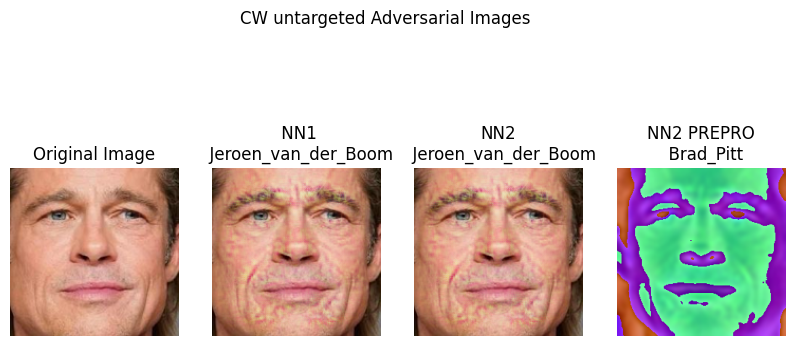

In [14]:
# Converti le immagini in uint8 per la visualizzazione
if test_img_numpy.dtype != np.uint8:
    test_img_numpy = (test_img_numpy * 255).astype(np.uint8)
    test_img_numpy = np.squeeze(test_img_numpy, axis=0)  # Rimuovi la dimensione batch extra
    test_img_numpy = np.transpose(test_img_numpy, (1, 2, 0))


# Prepara le immagini per la visualizzazione
# Rimuovi la dimensione batch extra e converti nel formato channels-last
test_images_adv = np.squeeze(test_images_adv, axis=0)
test_images_adv = np.transpose(test_images_adv, (1, 2, 0))

if test_images_adv.dtype != np.uint8:
    test_images_adv = (test_images_adv * 255).astype(np.uint8)

test_images_NN2_pre = test_images_NN2_pre.numpy()

test_images_NN2_pre = np.squeeze(test_images_NN2_pre, axis=0)
test_images_NN2_pre = np.transpose(test_images_NN2_pre, (1, 2, 0))

if test_images_NN2_pre.dtype != np.uint8:
    test_images_NN2_pre = (test_images_NN2_pre * 255).astype(np.uint8)

# Visualizza le immagini affiancate con Matplotlib
fig, (ax1, ax2,ax3,ax4) = plt.subplots(1, 4, figsize=(10, 5))

# Mostra l'immagine originale
ax1.imshow(test_img_numpy)
ax1.set_title('Original Image')
ax1.axis('off')

# Mostra l'immagine avversaria
ax2.imshow(test_images_adv)
ax2.set_title(f' NN1\n {predicted_label_nn1}')
ax2.axis('off')

ax3.imshow(test_images_adv)
ax3.set_title(f'NN2\n {predicted_label_nn2}')
ax3.axis('off')

ax4.imshow(test_images_NN2_pre)
ax4.set_title(f'NN2 PREPRO\n {predicted_label_nn2_pre}')
ax4.axis('off')

# Mostra la figura
plt.suptitle("CW untargeted Adversarial Images")
plt.show()


## Targeted Attack on all test set

In [ ]:
dataset_dir = "test_set_cropped/" 
binary_search_steps = 2
confidence = 0.5
max_iter = [15]
learning_rate = [1e-11,1e-10,1e-09,0.0000001,0.00001,0.003,0.01,0.1,1]
initial_const = [75]

correct_predictions_nn1 = 0
correct_misclassified_nn1 = 0
accuracy_for_learning_rate_targeted_nn1 = np.zeros((len(max_iter),len(initial_const),len(learning_rate)))      
perturbation_for_learning_rate_targeted_nn1 = np.zeros((len(max_iter),len(initial_const),len(learning_rate)))
accuracy_misclassified_for_learning_rate_targeted_nn1 = np.zeros((len(max_iter),len(initial_const),len(learning_rate)))

correct_predictions_nn2 = 0
correct_misclassified_nn2 = 0
accuracy_for_learning_rate_targeted_nn2 = np.zeros((len(max_iter),len(initial_const),len(learning_rate)))       
accuracy_misclassified_for_learning_rate_targeted_nn2 = np.zeros((len(max_iter),len(initial_const),len(learning_rate)))


correct_predictions_nn2_preprocessed = 0
correct_misclassified_nn2_preprocessed = 0
accuracy_for_learning_rate_targeted_nn2_preprocessed = np.zeros((len(max_iter),len(initial_const),len(learning_rate)))
accuracy_misclassified_for_learning_rate_targeted_nn2_preprocessed = np.zeros((len(max_iter),len(initial_const),len(learning_rate)))

target_class = 10
etichetta_target = LABELS[target_class]
print("ETICHETTA TARGET: ", etichetta_target)

targeted_labels = target_class*np.ones(LABELS.size)
one_hot_targeted_labels = tf.keras.utils.to_categorical(targeted_labels, num_classes = 8631)


print("Inizio Attacco CARLINI-WAGNER TARGETED")
for z in range(len(max_iter)):
    for i in range(len(initial_const)):
            for j in range(len(learning_rate)):   
                correct_predictions_nn1 = 0
                correct_predictions_nn2 = 0
                correct_predictions_nn2_preprocessed = 0
                correct_misclassified_nn1 = 0
                correct_misclassified_nn2 = 0
                correct_misclassified_nn2_preprocessed = 0
                total_images = 0
                perturbation = []
                
                attack = CarliniL2Method(classifier=model_nn1,
                                          binary_search_steps=binary_search_steps,
                                            confidence=confidence, max_iter=max_iter[z],
                                              learning_rate=learning_rate[j],
                                                initial_const=initial_const[i],
                                                  targeted=True)
                
                print("<---> Attacco con max_iter = {}| learning rate = {} | initial cost = {} <--->".format(max_iter[z],learning_rate[j],initial_const[i]))
                for filename in os.listdir(dataset_dir):
                    person_path = os.path.join(dataset_dir, filename)
                    test_img = load_image_NN1(person_path,device)
                    test_img = test_img.numpy()
                    test_images_adv = attack.generate(test_img,one_hot_targeted_labels)
                    
                    nn1_predictions = model_nn1.predict(test_images_adv,verbose = False)
                    differenza = test_images_adv - test_img
                    perturbation.append(np.linalg.norm(differenza))
                    test_images_NN2 = load_test_image_NN2(test_images_adv)
                    nn2_predictions = model_nn2.predict(test_images_NN2)

                    test_images_NN2_preprocessed = load_test_image_NN2_preprocessed(test_images_adv)
                    nn2_predictions_preprocessed = model_nn2.predict(test_images_NN2_preprocessed)

                    correct_label = re.sub(r'_\d+_face_0\.jpg$', '', filename)  
                      #Salvo le perturbazioni applicate su ogni immagine
            
                    predicted_label_nn1 = LABELS[np.array(nn1_predictions.argmax())]
                    predicted_label_nn2 = LABELS[np.array(nn2_predictions.argmax())]
                    predicted_label_nn2_preprocessed = LABELS[np.array(nn2_predictions_preprocessed.argmax())]
                    print("Etichetta Corretta: {} | Predetto: {}  probabilità {} perturbazione applicata {} | Predetto NN2: {} | Predetto NN2PREP: {}".format(correct_label,predicted_label_nn1,nn1_predictions[0][nn1_predictions.argmax()],perturbation[-1],predicted_label_nn2,predicted_label_nn2_preprocessed))
                    total_images+=1
                    
                    predicted_label_nn1 = str(predicted_label_nn1)  
                    predicted_label_nn2 = str(predicted_label_nn2)
                    predicted_label_nn2_preprocessed = str(predicted_label_nn2_preprocessed)
                    
                    if correct_label in predicted_label_nn1:
                        correct_predictions_nn1 += 1
                    
                    if correct_label in predicted_label_nn2:
                        correct_predictions_nn2 += 1

                    if correct_label in predicted_label_nn2_preprocessed:
                        correct_predictions_nn2_preprocessed += 1

                    #---------------------MISCLASSIFIED------------------------------------------

                    if  predicted_label_nn1 in etichetta_target:  
                        correct_misclassified_nn1 += 1   #Se il modello predice l'etichetta target allora è correttamente misclassificato

                    if  predicted_label_nn2 in etichetta_target:   #se l'attacco su NN2 Correttamente riuscito
                        correct_misclassified_nn2 += 1 

                    if  predicted_label_nn2_preprocessed in etichetta_target:    #se l'attacco su NN2 Correttamente riuscito
                        correct_misclassified_nn2_preprocessed += 1   
                
                    if total_images == 500:
                        print("Sei a 500 Immagini initial_cost:{} | learning_rate:{}".format(initial_const[i], learning_rate[j]))

                if total_images != 0:
                    # NN1    
                    if len(perturbation) == total_images:
                        # In media quanta pertubazione è stata applicata su ogni immagine
                        perturbation_for_learning_rate_targeted_nn1[z][i][j] = (sum(perturbation)/total_images)
                            
                    final_accuracy_nn1 = correct_predictions_nn1/total_images          # Accuracy su tutte le immagini
                    accuracy_for_learning_rate_targeted_nn1[z][i][j] = final_accuracy_nn1

                    final_accuracy_misclassified_nn1 = correct_misclassified_nn1/total_images
                    accuracy_misclassified_for_learning_rate_targeted_nn1[z][i][j] = final_accuracy_misclassified_nn1

                    #nn2
                    final_accuracy_nn2 = correct_predictions_nn2/total_images
                    accuracy_for_learning_rate_targeted_nn2[z][i][j] = final_accuracy_nn2

                    final_accuracy_misclassified_nn2 = correct_misclassified_nn2/total_images
                    accuracy_misclassified_for_learning_rate_targeted_nn2[z][i][j] = final_accuracy_misclassified_nn2
                    
                    #PREPROCESSED
                    final_accuracy_nn2_preprocessed = correct_predictions_nn2_preprocessed/total_images
                    accuracy_for_learning_rate_targeted_nn2_preprocessed[z][i][j] = final_accuracy_nn2_preprocessed

                    final_accuracy_misclassified_nn2_preprocessed = correct_misclassified_nn2_preprocessed/total_images
                    accuracy_misclassified_for_learning_rate_targeted_nn2_preprocessed[z][i][j] = final_accuracy_misclassified_nn2_preprocessed

                else:
                    print("ERRORE TOTAL IMAGE == 0 ERRORE")
        
    print("--------------------------------------------------------------------------------------------------------------------------------------------------------------------")
    print("")
    
                

### Plot results

#### Grafico accuracy/perturbazione NN1

In [ ]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots()

ax.plot(perturbation_for_learning_rate_nn1[0][0], accuracy_for_learning_rate_nn1[0][0], 'r', label='NN1 max_iter: 15')

legend = ax.legend(loc='upper right', shadow=True, fontsize='small')
legend.get_frame().set_facecolor('#00FFCC')

plt.ylabel('Accuracy')
plt.xlabel("Perturbazione")
plt.show()

#### Grafico NN1

In [ ]:


fig, ax = plt.subplots()
ax.plot(learning_rate, accuracy_for_learning_rate_targeted_nn1[0][0], 'black', label='NN1')

legend = ax.legend(loc='upper right', shadow=True, fontsize='small')
legend.get_frame().set_facecolor('#00FFCC')

plt.ylabel('Accuracy')
plt.xlabel('Learning Rate')


plt.show()

#### MISCLASSIFIED NN1

In [ ]:

fig, ax = plt.subplots()
ax.plot(learning_rate, accuracy_misclassified_for_learning_rate_targeted_nn1[0][0], 'cyan', label='NN1')


legend = ax.legend(loc='upper right', shadow=True, fontsize='small')
legend.get_frame().set_facecolor('#00FFCC')

plt.ylabel('Misclassified Rate')
plt.xlabel('Learning Rate')


plt.show()

#### Accuracy NN2 

In [ ]:


fig, ax = plt.subplots()
ax.plot(learning_rate, accuracy_for_learning_rate_targeted_nn2[0][0], 'black', label='NN2')
ax.plot(learning_rate, accuracy_misclassified_for_learning_rate_targeted_nn2[0][0], '--r', label='NN2')

legend = ax.legend(loc='upper right', shadow=True, fontsize='small')
legend.get_frame().set_facecolor('#00FFCC')

plt.ylabel('Accuracy')
plt.xlabel('Learning Rate')


plt.show()

#### Misclassified NN2

In [ ]:

fig, ax = plt.subplots()

ax.plot(learning_rate, accuracy_misclassified_for_learning_rate_targeted_nn2[0][0], 'r', label='NN2')


legend = ax.legend(loc='upper right', shadow=True, fontsize='small')
legend.get_frame().set_facecolor('#00FFCC')

plt.ylabel('Misclassified Rate')
plt.xlabel('Learning Rate')


plt.show()

#### Confronto NN2 e NN1

In [ ]:
# plot accuracy/Attack strength

fig, ax = plt.subplots()
ax.plot(learning_rate, accuracy_for_learning_rate_targeted_nn1[0][0], 'black', label='NN1')
ax.plot(learning_rate, accuracy_for_learning_rate_targeted_nn2[0][0], 'violet', label='NN2')


legend = ax.legend(loc='upper right', shadow=True, fontsize='small')
legend.get_frame().set_facecolor('#00FFCC')

plt.ylabel('Accuracy')
plt.xlabel('Learning Rate')


plt.show()

#### Accuracy Preprocessed

In [ ]:

fig, ax = plt.subplots()
ax.plot(learning_rate, accuracy_for_learning_rate_nn2_preprocessed[0][0], 'black', label='NN2_Prep')

legend = ax.legend(loc='upper right', shadow=True, fontsize='small')
legend.get_frame().set_facecolor('#00FFCC')

plt.ylabel('Accuracy')
plt.xlabel('Learning Rate')


plt.show()

#### Confronto misclassified NN2 e NN2prep

In [ ]:
# plot accuracy/Attack strength

fig, ax = plt.subplots()
ax.plot(learning_rate, accuracy_misclassified_for_learning_rate_targeted_nn2[0][0], 'black', label='NN2')
ax.plot(learning_rate, accuracy_misclassified_for_learning_rate_targeted_nn2_preprocessed[0][0], '--r', label='NN2_Prep.')



legend = ax.legend(loc='upper right', shadow=True, fontsize='small')
legend.get_frame().set_facecolor('#00FFCC')

plt.ylabel('Misclassified Rate')
plt.xlabel('Learning Rate')


plt.show()

#### Confronto NN1 NN2 NN2Prep

In [ ]:
# plot accuracy/Attack strength

fig, ax = plt.subplots()
ax.plot(learning_rate, accuracy_for_learning_rate_targeted_nn1[0][0], 'black', label='NN1')
ax.plot(learning_rate, accuracy_for_learning_rate_targeted_nn2[0][0], 'violet', label='NN2')
ax.plot(learning_rate, accuracy_for_learning_rate_targeted_nn2_preprocessed[0][0], 'blue', label='NN2 Prep')


legend = ax.legend(loc='upper right', shadow=True, fontsize='small')
legend.get_frame().set_facecolor('#00FFCC')

plt.ylabel('Accuracy')
plt.xlabel('Learning Rate')


plt.show()

## Single sample Targeted attack

In [15]:
binary_search_steps = 2
confidence = 0.5
max_iter = 15
learning_rate = 0.07
initial_const = 75

attack = CarliniL2Method(classifier=model_nn1, binary_search_steps=binary_search_steps, confidence=confidence, max_iter=max_iter, learning_rate=learning_rate, initial_const=initial_const, targeted=True)

In [16]:

dataset_dir = "test_set_cropped/"
filename = "Fernando_Llorente_4_face_0.jpg"
person_path = os.path.join(dataset_dir, filename)



target_class = 10
etichetta_target = LABELS[target_class]
print("ETICHETTA TARGET: ", etichetta_target)

targeted_labels = target_class*np.ones(LABELS.size)
one_hot_targeted_labels = tf.keras.utils.to_categorical(targeted_labels, num_classes = 8631)


test_img = load_image_NN1(person_path, device)
test_img_numpy = test_img.numpy()

test_images_adv = attack.generate(test_img_numpy, one_hot_targeted_labels)
model_predictions = model_nn1.predict(test_images_adv)

nn1_predictions = model_nn1.predict(test_images_adv)

test_image_nn2 = load_test_image_NN2(test_images_adv)

nn2_predictions = model_nn2.predict(test_image_nn2)

test_images_NN2_pre = load_test_image_NN2_preprocessed(test_images_adv)


nn2_predictions_pre = model_nn2.predict(test_images_NN2_pre)


correct_label = re.sub(r'_\d+_face_0\.jpg$', '', filename) 


predicted_label_nn1 = LABELS[np.array(nn1_predictions.argmax())]
predicted_label_nn2 = LABELS[np.array(nn2_predictions.argmax())]
predicted_label_nn2_pre = LABELS[np.array(nn2_predictions_pre.argmax())]
print("NN1{} con probabilità {}".format(predicted_label_nn1,nn1_predictions[0][nn1_predictions.argmax()]))
print("NN2{} con probabilità {}".format(predicted_label_nn2,nn2_predictions[0][nn2_predictions.argmax()]))
print("NN2{} con probabilità {}".format(predicted_label_nn2_pre,nn2_predictions_pre[0][nn2_predictions_pre.argmax()]))


                    

ETICHETTA TARGET:   Aaron_Hernandez


C&W L_2: 100%|██████████| 1/1 [00:09<00:00,  9.18s/it]


NN1 Aaron_Hernandez con probabilità 12.529793739318848
NN2 Aaron_Hernandez con probabilità 9.64253044128418
NN2 Fernando_Llorente con probabilità 13.204760551452637


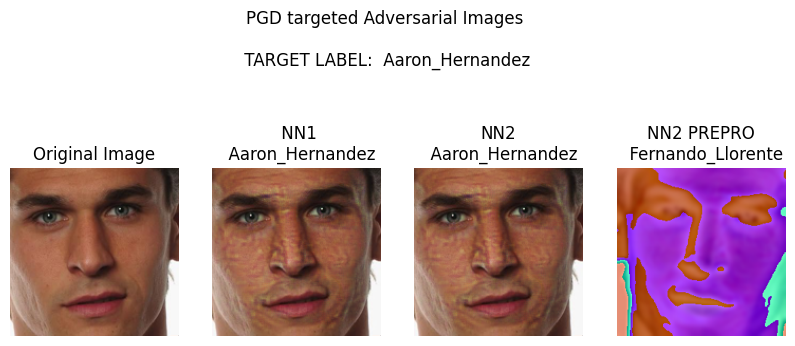

In [17]:
# Converti le immagini in uint8 per la visualizzazione
if test_img_numpy.dtype != np.uint8:
    test_img_numpy = (test_img_numpy * 255).astype(np.uint8)
    test_img_numpy = np.squeeze(test_img_numpy, axis=0)  # Rimuovi la dimensione batch extra
    test_img_numpy = np.transpose(test_img_numpy, (1, 2, 0))


# Prepara le immagini per la visualizzazione
# Rimuovi la dimensione batch extra e converti nel formato channels-last
test_images_adv = np.squeeze(test_images_adv, axis=0)
test_images_adv = np.transpose(test_images_adv, (1, 2, 0))

if test_images_adv.dtype != np.uint8:
    test_images_adv = (test_images_adv * 255).astype(np.uint8)

test_images_NN2_pre = test_images_NN2_pre.numpy()

test_images_NN2_pre = np.squeeze(test_images_NN2_pre, axis=0)
test_images_NN2_pre = np.transpose(test_images_NN2_pre, (1, 2, 0))

if test_images_NN2_pre.dtype != np.uint8:
    test_images_NN2_pre = (test_images_NN2_pre * 255).astype(np.uint8)

# Visualizza le immagini affiancate con Matplotlib
fig, (ax1, ax2,ax3,ax4) = plt.subplots(1, 4, figsize=(10, 5))

# Mostra l'immagine originale
ax1.imshow(test_img_numpy)
ax1.set_title('Original Image')
ax1.axis('off')

# Mostra l'immagine avversaria
ax2.imshow(test_images_adv)
ax2.set_title(f' NN1\n {predicted_label_nn1}')
ax2.axis('off')

ax3.imshow(test_images_adv)
ax3.set_title(f'NN2\n {predicted_label_nn2}')
ax3.axis('off')

ax4.imshow(test_images_NN2_pre)
ax4.set_title(f'NN2 PREPRO\n {predicted_label_nn2_pre}')
ax4.axis('off')

# Mostra la figura
plt.suptitle(f'PGD targeted Adversarial Images\n\n TARGET LABEL: {LABELS[target_class]}')
plt.show()
